# ArangoDB NetworkX Adapter Getting Started Guide  

<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/4.0.0/examples/ArangoDB_NetworkX_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![arangodb](https://github.com/arangoml/networkx-adapter/blob/master/examples/assets/logos/ArangoDB_logo.png?raw=1)
![networkX](https://github.com/arangoml/networkx-adapter/blob/master/examples/assets/logos/networkx_logo.svg?raw=1) 

Version: 4.0.0

Objective: Export Graphs from [ArangoDB](https://www.arangodb.com/), a multi-model Graph Database, to [NetworkX](https://networkx.github.io/), the swiss army knife for graph analysis in python, and vice-versa.

# Setup

In [ ]:
%%capture
!git clone -b 4.0.0 --single-branch https://github.com/arangoml/networkx-adapter.git
!pip install adbnx-adapter==4.0.0
!pip install adb-cloud-connector

# For drawing purposes
!pip install matplotlib

In [16]:
# All imports

import networkx as nx

from adbnx_adapter import ADBNX_Adapter, ADBNX_Controller
from adbnx_adapter.typings import Json, ArangoMetagraph, NxId, NxData

from arango import ArangoClient
from adb_cloud_connector import get_temp_credentials

import math
import json
import logging
import matplotlib.pyplot as plt
from typing import List

# Understanding NetworkX

(referenced from [networkx.org/documentation](https://networkx.org/documentation/stable/reference/index.html))

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It provides:
* tools for the study of the structure and dynamics of social, biological, and infrastructure networks;
* a standard programming interface and graph implementation that is suitable for many applications;
* a rapid development environment for collaborative, multidisciplinary projects;
* an interface to existing numerical algorithms and code written in C, C++, and FORTRAN; and
* the ability to painlessly work with large nonstandard data sets.

With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more.


The following basic graph types are provided as Python classes:

`Graph`
* This class implements an undirected graph. It ignores multiple edges between two nodes. It does allow self-loop edges between a node and itself.

`DiGraph`
* Directed graphs, that is, graphs with directed edges. Provides operations common to directed graphs, (a subclass of Graph).

`MultiGraph`
* A flexible graph class that allows multiple undirected edges between pairs of nodes. The additional flexibility leads to some degradation in performance, though usually not significant.

`MultiDiGraph`
A directed version of a MultiGraph.

**Note: To maximize NetworkX usability, the ArangoDB-NetworkX Adapter creates NetworkX graphs of type `MultiDiGraph`. You can to the NetworkX documentation for converting a `MultiDiGraph` to other types.**


However, for now, let's take a look at creating a regular `Graph`:

In [26]:
G = nx.Graph()
G.add_edge(1, 2)  # default edge data=1
G.add_edge(2, 3, weight=0.9)  # specify edge data

Edge attributes can be anything:

In [27]:
G.add_edge('y', 'x', function=math.cos)
G.add_node(math.cos)  # any hashable can be a node

You can add many edges at one time:

In [28]:
elist = [(1, 2), (2, 3), (1, 4), (4, 2)]
G.add_edges_from(elist)
elist = [('a', 'b', 5.0), ('b', 'c', 3.0), ('a', 'c', 1.0), ('c', 'd', 7.3)]
G.add_weighted_edges_from(elist)

### Algorithms

A number of graph algorithms are provided with NetworkX. These include shortest path, and breadth first search, clustering and isomorphism algorithms and others.

As an example here is code to use Dijkstra’s algorithm to find the shortest weighted path:

In [29]:
G = nx.Graph()
e = [('a', 'b', 0.3), ('b', 'c', 0.9), ('a', 'c', 0.5), ('c', 'd', 1.2)]
G.add_weighted_edges_from(e)
print(nx.dijkstra_path(G, 'a', 'd'))

['a', 'c', 'd']


### Drawing

While NetworkX is not designed as a network drawing tool, we provide a simple interface to drawing packages and some simple layout algorithms.

The basic drawing functions essentially place the nodes on a scatterplot using the positions you provide via a dictionary or the positions are computed with a layout function. The edges are lines between those dots:

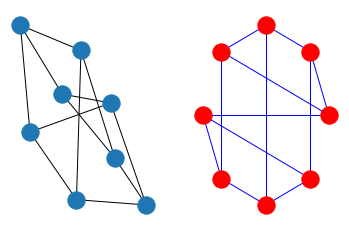

In [30]:
G = nx.cubical_graph()
subax1 = plt.subplot(121)
nx.draw(G)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

### Data Structure

NetworkX uses a “dictionary of dictionaries of dictionaries” as the basic network data structure. This allows fast lookup with reasonable storage for large sparse networks. The keys are nodes so G[u] returns an adjacency dictionary keyed by neighbor to the edge attribute dictionary. A view of the adjacency data structure is provided by the dict-like object G.adj as e.g. for node, nbrsdict in G.adj.items():. The expression G[u][v] returns the edge attribute dictionary itself. A dictionary of lists would have also been possible, but not allow fast edge detection nor convenient storage of edge data.

As an example, here is a representation of an undirected graph with the edges 

In [31]:
G = nx.Graph()
G.add_edge('A', 'B')
G.add_edge('B', 'C')
print(G.adj)

{'A': {'B': {}}, 'B': {'A': {}, 'C': {}}, 'C': {'B': {}}}


Graphs provide two interfaces to the edge data attributes: adjacency and edges. So G[u][v]['width'] is the same as G.edges[u, v]['width'].

In [32]:
G = nx.Graph()
G.add_edge(1, 2, color='red', weight=0.84, size=300)
print(G[1][2]['size'])
print(G.edges[1, 2]['color'])

300
red


# Create a Temporary ArangoDB Cloud Instance

In [3]:
# Request temporary instance from the managed ArangoDB Cloud Service.
con = get_temp_credentials()
print(json.dumps(con, indent=2))

# Connect to the db via the python-arango driver
db = ArangoClient(hosts=con["url"]).db(con["dbName"], con["username"], con["password"], verify=True)

Log: requesting new credentials...
Succcess: new credentials acquired
{
  "dbName": "TUTloq6b9bm86fckte1cw1tri",
  "username": "TUT6mgdqojzsww9q4df7m0iw",
  "password": "TUTia8zrhyoicsde3wfhnoexi",
  "hostname": "tutorials.arangodb.cloud",
  "port": 8529,
  "url": "https://tutorials.arangodb.cloud:8529"
}


Feel free to use to above URL to checkout the UI!

# Data Import

For demo purposes, we will be using the [ArangoDB Fraud Detection example graph](https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Fraud_Detection.ipynb), and the [ArangoDB IMDB Dataset](https://github.com/arangodb/example-datasets/tree/master/Graphs/IMDB).

In [4]:
!chmod -R 755 networkx-adapter/
!./networkx-adapter/tests/assets/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "networkx-adapter/examples/data/fraud_dump" --include-system-collections true
!./networkx-adapter/tests/assets/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "networkx-adapter/examples/data/imdb_dump" --include-system-collections true

2022-05-25T17:44:57Z [275] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://tutorials.arangodb.cloud:8529'
2022-05-25T17:44:57Z [275] INFO [abeb4] {restore} Database name in source dump is 'fraud-detection'
2022-05-25T17:44:57Z [275] INFO [9b414] {restore} # Re-creating document collection '_analyzers'...
2022-05-25T17:44:57Z [275] INFO [9b414] {restore} # Re-creating document collection '_appbundles'...
2022-05-25T17:45:02Z [275] INFO [9b414] {restore} # Re-creating document collection '_apps'...
2022-05-25T17:45:02Z [275] INFO [9b414] {restore} # Re-creating document collection '_aqlfunctions'...
2022-05-25T17:45:02Z [275] INFO [9b414] {restore} # Re-creating document collection '_graphs'...
2022-05-25T17:45:02Z [275] INFO [9b414] {restore} # Re-creating document collection '_modules'...
2022-05-25T17:45:02Z [275] INFO [9b414] {restore} # Re-creating document collection 'account'...
2022-05-25T17:45:03Z [275] INFO [9b414] {restore} # Re-creating document collection 'bank'...


# Instantiate the Adapter

Connect the ArangoDB-Networkx Adapter to our temporary ArangoDB cluster:

In [5]:
adbnx_adapter = ADBNX_Adapter(db)

[2022/05/25 17:45:29 +0000] [61] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'TUTloq6b9bm86fckte1cw1tri'


# <u>ArangoDB to NetworkX</u>



#### Via ArangoDB Graph Name

Data source
* ArangoDB Fraud-Detection Graph

Package methods used
* [`adbnx_adapter.adapter.arangodb_graph_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L177-L196)

Important notes
* The `name` parameter in this case must point to an existing ArangoDB graph in your ArangoDB instance. 


[2022/05/25 17:45:33 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'fraud-detection' Graph



--------------------
MultiDiGraph named 'fraud-detection' with 71 nodes and 116 edges
[('account/10000011', {'_key': '10000011', '_id': 'account/10000011', '_rev': '_eNvQcLi---', 'Balance': 5331, 'Status': 'active', 'account_opening_date': '2018-3-13', 'account_type': 'checking', 'bank_id': 10000000001, 'branch_id': 10001, 'customer_id': 10000009, 'rank': 0.0021126761566847563}), ('account/10000016', {'_key': '10000016', '_id': 'account/10000016', '_rev': '_eNvQcLi--_', 'Balance': 7630, 'Status': 'active', 'account_opening_date': '2018-10-15', 'account_type': 'checking', 'bank_id': 10000000002, 'branch_id': 10005, 'customer_id': 10000004, 'rank': 0.003122549969702959}), ('account/10000003', {'_key': '10000003', '_id': 'account/10000003', '_rev': '_eNvQcLi--A', 'Balance': 1433, 'Status': 'active', 'account_opening_date': '2017-10-24', 'account_type': 'checking', 'bank_id': 10000000002, 'branch_id': 10006, 'customer_id': 10000004, 'rank': 0.00524971354752779}), ('account/10000029', {'_k

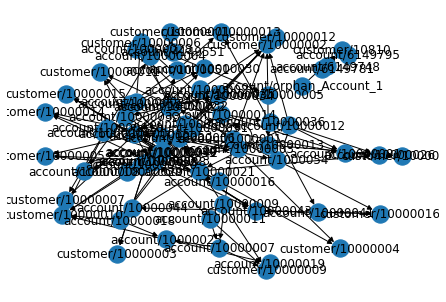

In [6]:
# Define graph name
graph_name = "fraud-detection"

# Create NetworkX graph from ArangoDB graph
nx_g = adbnx_adapter.arangodb_graph_to_networkx(graph_name)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = adbnx_adapter.arangodb_graph_to_networkx(graph_name, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))
print('--------------------\n')
nx.draw(nx_g, with_labels=True)

#### Via ArangoDB Collection Names

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbnx_adapter.adapter.arangodb_collections_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L147-L175)

Important notes
* The `name` parameter in this case is simply for naming your NetworkX graph.
* The `vertex_collections` & `edge_collections` parameters must point to existing ArangoDB collections within your ArangoDB instance.

[2022/05/25 17:45:39 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'fraud-detection' Graph



--------------------
MultiDiGraph named 'fraud-detection' with 88 nodes and 120 edges
[('account/10000011', {'_key': '10000011', '_id': 'account/10000011', '_rev': '_eNvQcLi---', 'Balance': 5331, 'Status': 'active', 'account_opening_date': '2018-3-13', 'account_type': 'checking', 'bank_id': 10000000001, 'branch_id': 10001, 'customer_id': 10000009, 'rank': 0.0021126761566847563}), ('account/10000016', {'_key': '10000016', '_id': 'account/10000016', '_rev': '_eNvQcLi--_', 'Balance': 7630, 'Status': 'active', 'account_opening_date': '2018-10-15', 'account_type': 'checking', 'bank_id': 10000000002, 'branch_id': 10005, 'customer_id': 10000004, 'rank': 0.003122549969702959}), ('account/10000003', {'_key': '10000003', '_id': 'account/10000003', '_rev': '_eNvQcLi--A', 'Balance': 1433, 'Status': 'active', 'account_opening_date': '2017-10-24', 'account_type': 'checking', 'bank_id': 10000000002, 'branch_id': 10006, 'customer_id': 10000004, 'rank': 0.00524971354752779}), ('account/10000029', {'_k

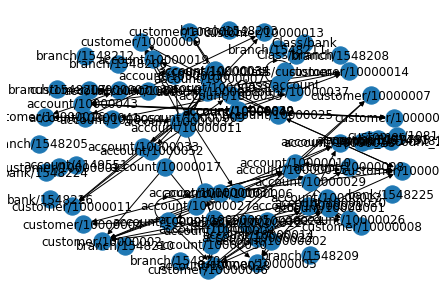

In [7]:
# Define collection
vertex_collections = {"account", "bank", "branch", "Class", "customer"}
edge_collections = {"accountHolder", "Relationship", "transaction"}

# Create NetworkX graph from ArangoDB collections
nx_g = adbnx_adapter.arangodb_collections_to_networkx("fraud-detection", vertex_collections, edge_collections)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = adbnx_adapter.arangodb_collections_to_networkx("fraud-detection", vertex_collections, edge_collections, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))
print('--------------------\n')
nx.draw(nx_g, with_labels=True)

#### Via ArangoDB Metagraph

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbnx_adapter.adapter.arangodb_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L67-L145)

Important notes
* The `name` parameter in this case is simply for naming your NetworkX graph.
* The `metagraph` parameter should contain collections & associated document attributes names that exist within your ArangoDB instance.

[2022/05/25 17:45:46 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'fraud-detection' Graph



--------------------
MultiDiGraph named 'fraud-detection' with 88 nodes and 120 edges
[('account/10000011', {'Balance': 5331, '_id': 'account/10000011', 'account_type': 'checking', 'customer_id': 10000009, 'rank': 0.0021126761566847563}), ('account/10000016', {'Balance': 7630, '_id': 'account/10000016', 'account_type': 'checking', 'customer_id': 10000004, 'rank': 0.003122549969702959}), ('account/10000003', {'Balance': 1433, '_id': 'account/10000003', 'account_type': 'checking', 'customer_id': 10000004, 'rank': 0.00524971354752779}), ('account/10000029', {'Balance': 2201, '_id': 'account/10000029', 'account_type': 'checking', 'customer_id': 10000010, 'rank': 0.0021126761566847563}), ('account/10000005', {'Balance': 4837, '_id': 'account/10000005', 'account_type': 'checking', 'customer_id': 10000002, 'rank': 0.004550427198410034}), ('account/10000032', {'Balance': 5817, '_id': 'account/10000032', 'account_type': 'checking', 'customer_id': 10000011, 'rank': 0.0036875137593597174}), ('ac

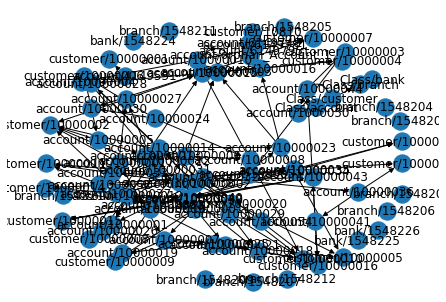

In [8]:
# Define metagraph
fraud_detection_metagraph = {
    "vertexCollections": {
        "account": {"Balance", "account_type", "customer_id", "rank"},
        "bank": {"Country", "Id", "bank_id", "bank_name"},
        "branch": {"City", "Country", "Id", "bank_id", "branch_id", "branch_name"},
        "Class": {"concrete", "label", "name"},
        "customer": {"Name", "Sex", "Ssn", "rank"},
    },
    "edgeCollections": {
        "accountHolder": {},
        "Relationship": {"label", "name", "relationshipType"},
        "transaction": {"transaction_amt", "sender_bank_id", "receiver_bank_id"},
    },
}

# Create NetworkX Graph from attributes
nx_g = adbnx_adapter.arangodb_to_networkx('fraud-detection',  fraud_detection_metagraph)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = adbnx_adapter.arangodb_to_networkx('fraud-detection',  fraud_detection_metagraph, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))
print('--------------------\n')
nx.draw(nx_g, with_labels=True)

#### Via ArangoDB Metagraph with a custom ADBNX_Controller & verbose logging

Data source
* ArangoDB IMDB Dataset

Package methods used
* [`adbnx_adapter.adapter.arangodb_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L67-L145)
* [`adbnx_adapter.controller._prepare_arangodb_vertex()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/controller.py#L19-L33)

Important notes
* The `name` parameter in this case is simply for naming your NetworkX graph.
* The `metagraph` parameter should contain collections & associated document attributes names that exist within your ArangoDB instance.
* We are creating a custom `ADBNX_Controller` to specify *how* to convert our ArangoDB vertices into NetworkX nodes. View the default `ADBNX_Controller` [here](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/controller.py#L10).

In [9]:
# Define metagraph
imdb_metagraph = {
    "vertexCollections": {"Users": {"Age", "Gender"}, "Movies": {}},
    "edgeCollections": {"Ratings": {"Rating"}},
}

class IMDB_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.

    You can derive your own custom ADBNX_Controller.
    """

    # We re-define how vertex pre-insertion should be treated, specifically for the IMDB dataset.
    def _prepare_arangodb_vertex(self, adb_vertex: Json, col: str) -> None:
        """Prepare an ArangoDB vertex before it gets inserted into the NetworkX
        graph.

        Given an ArangoDB vertex, you can modify it before it gets inserted
        into the NetworkX graph, and/or derive a custom node id for NetworkX
        to use by updating the "_id" attribute of the vertex (otherwise the
        vertex's current "_id" value will be used)

        :param adb_vertex: The ArangoDB vertex object to (optionally) modify.
        :type adb_vertex: adbnx_adapter.typings.Json
        :param col: The ArangoDB collection the vertex belongs to.
        :type col: str
        """
        adb_vertex["bipartite"] = col == "Users" # New bipartite attribute logic
        adb_vertex["_id"] = "new_" + adb_vertex["_id"] # New node ID


    # We're not interested in re-defining pre-insertion handling for edges, so we leave it alone
    # def _prepare_arangodb_edge(self, adb_edge: Json, col: str) -> None:
    #   return

# Instantiate the custom adapter
imdb_adbnx_adapter = ADBNX_Adapter(db, IMDB_ADBNX_Controller())

# You can also change the adapter's logging level for access to 
# silent, regular, or verbose logging (logging.WARNING, logging.INFO, logging.DEBUG)
imdb_adbnx_adapter.set_logging(logging.DEBUG) # verbose logging

# Create NetworkX Graph from metagraph using the custom IMDB_ArangoDB_Networx_Adapter
nx_g = imdb_adbnx_adapter.arangodb_to_networkx("IMDBGraph", imdb_metagraph)

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print('--------------------\n')

[2022/05/25 17:45:52 +0000] [61] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'TUTloq6b9bm86fckte1cw1tri'
[2022/05/25 17:45:52 +0000] [61] [DEBUG] - adbnx_adapter: Starting arangodb_to_networkx(IMDBGraph, ...):
[2022/05/25 17:45:52 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'Users' vertices
[2022/05/25 17:45:52 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'Movies' vertices
[2022/05/25 17:45:52 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'Ratings' edges
[2022/05/25 17:45:55 +0000] [61] [DEBUG] - adbnx_adapter: Inserting 2625 vertices and 65499 edges
[2022/05/25 17:45:56 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'IMDBGraph' Graph



--------------------
MultiDiGraph named 'IMDBGraph' with 2625 nodes and 65499 edges
[('new_Users/1', {'Age': 35, 'Gender': 'M', '_id': 'new_Users/1', 'bipartite': True}), ('new_Users/2', {'Age': 53, 'Gender': 'F', '_id': 'new_Users/2', 'bipartite': True}), ('new_Users/3', {'Age': 23, 'Gender': 'M', '_id': 'new_Users/3', 'bipartite': True}), ('new_Users/4', {'Age': 24, 'Gender': 'M', '_id': 'new_Users/4', 'bipartite': True}), ('new_Users/5', {'Age': 33, 'Gender': 'F', '_id': 'new_Users/5', 'bipartite': True}), ('new_Users/6', {'Age': 42, 'Gender': 'M', '_id': 'new_Users/6', 'bipartite': True}), ('new_Users/7', {'Age': 57, 'Gender': 'M', '_id': 'new_Users/7', 'bipartite': True}), ('new_Users/8', {'Age': 36, 'Gender': 'M', '_id': 'new_Users/8', 'bipartite': True}), ('new_Users/9', {'Age': 29, 'Gender': 'M', '_id': 'new_Users/9', 'bipartite': True}), ('new_Users/10', {'Age': 53, 'Gender': 'M', '_id': 'new_Users/10', 'bipartite': True}), ('new_Users/11', {'Age': 39, 'Gender': 'F', '_id': '

# <u>NetworkX to ArangoDB</u>

#### Grid Graph

Data source
* [NetworkX Grid Graph](https://networkx.org/documentation/stable/auto_examples/basic/plot_read_write.html#sphx-glr-auto-examples-basic-plot-read-write-py)

Package methods used
* [`adbnx_adapter.adapter.networkx_to_arangodb()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L198-L332)

Important notes
* The `edge_definitions` parameter should contain a list of valid vertex relationships along with their related edge collections. See its [official documentation](https://docs.python-arango.com/en/main/graph.html#edge-definitions) for more details.
* We are using a `batch_size` value of 1 to demo to users that this feature exists.
* A custom `ADBNX Controller` is **not** required here. This is because this graph only has 1 vertex collection (`Grid_Node_v1`), and 1 edge collection (`to_v1`). See the edge definitions below 

[2022/05/25 17:46:03 +0000] [61] [DEBUG] - adbnx_adapter: Starting networkx_to_arangodb('Grid_v1', ...):
[2022/05/25 17:46:03 +0000] [61] [DEBUG] - adbnx_adapter: Is graph 'Grid_v1' homogeneous? True
[2022/05/25 17:46:03 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 25 NetworkX nodes
[2022/05/25 17:46:03 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 40 NetworkX edges
[2022/05/25 17:46:03 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 25 documents into 'Grid_Node_v1'
[2022/05/25 17:46:04 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 40 documents into 'to_v1'
[2022/05/25 17:46:04 +0000] [61] [INFO] - adbnx_adapter: Created ArangoDB 'Grid_v1' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6mgdqojzsww9q4df7m0iw
Password: TUTia8zrhyoicsde3wfhnoexi
Database: TUTloq6b9bm86fckte1cw1tri
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTloq6b9bm86fckte1cw1tri/_admin/aardvark/index.html#graph/Grid_v1



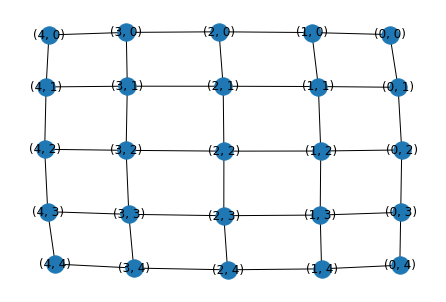

In [10]:
# Load the nx graph & draw it
grid_nx_g = nx.grid_2d_graph(5, 5)
nx.draw(grid_nx_g, with_labels=True)

# We must provide edge definitions to create the ArangoDB graph
# Since this graph is Homogeneous, we only need one edge definition.
edge_definitions = [
    {
        "edge_collection": "to_v1",
        "from_vertex_collections": ["Grid_Node_v1"],
        "to_vertex_collections": ["Grid_Node_v1"],
    }
]

name = "Grid_v1"

# Delete graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
grid_adb_g = adbnx_adapter.networkx_to_arangodb(name, grid_nx_g, edge_definitions)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")

#### Divisibility Graph

Data source
* No source

Package methods used
* [`adbnx_adapter.adapter.networkx_to_arangodb()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L198-L332)


Important notes
* Even if this graph has more than 1 vertex collection, a custom `ADBNX Controller` is still **not** required here. This is because the NetworkX Node IDs are already formatted to the ArangoDB standard, so the default ADBNX Controller will take care of node identification (see [`_identify_networkx_node()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/controller.py#L49-L72))

In [13]:
# Create the NetworkX graph
edges = [
    (f"numbers_j/{j}", f"numbers_i/{i}", j / i)
    for i in range(1, 101)
    for j in range(1, 101)
    if j % i == 0
]
nx_graph = nx.MultiDiGraph()
nx_graph.add_weighted_edges_from(edges)

# Specify ArangoDB edge definitions
edge_definitions = [
    {
        "edge_collection": "is_divisible_by",
        "from_vertex_collections": ["numbers_j"],
        "to_vertex_collections": ["numbers_i"],
    }
]

# Create ArangoDB graph from NetworkX
name = "DivisibilityGraph"
db.delete_graph(name, drop_collections=True, ignore_missing=True)
adb_graph = adbnx_adapter.networkx_to_arangodb(name, nx_graph, edge_definitions, keyify_nodes=True)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")

[2022/05/25 17:46:42 +0000] [61] [DEBUG] - adbnx_adapter: Starting networkx_to_arangodb('DivisibilityGraph', ...):
[2022/05/25 17:46:42 +0000] [61] [DEBUG] - adbnx_adapter: Is graph 'DivisibilityGraph' homogeneous? False
[2022/05/25 17:46:42 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 200 NetworkX nodes
[2022/05/25 17:46:42 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 482 NetworkX edges
[2022/05/25 17:46:42 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 100 documents into 'numbers_j'
[2022/05/25 17:46:43 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 100 documents into 'numbers_i'
[2022/05/25 17:46:43 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 482 documents into 'is_divisible_by'
[2022/05/25 17:46:43 +0000] [61] [INFO] - adbnx_adapter: Created ArangoDB 'DivisibilityGraph' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6mgdqojzsww9q4df7m0iw
Password: TUTia8zrhyoicsde3wfhnoexi
Database: TUTloq6b9bm86fckte1cw1tri
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTloq6b9bm86fckte1cw1tri/_admin/aardvark/index.html#graph/DivisibilityGraph


#### School Graph with a custom ADBNX_Controller

Data source
* No source, the graph data is arbitrary

Package methods used
* [`adbnx_adapter.adapter.networkx_to_arangodb()`](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/adapter.py#L198-L332)

Important notes
* Here we demonstrate the functionality of having a custom `ADBNX_Controller`, that overrides the [default ADBNX_Controller](https://github.com/arangoml/networkx-adapter/blob/4.0.0/adbnx_adapter/controller.py).
* Recall that a custom ADBNX Controller for `NetworkX --> ArangoDB` functionality is almost always needed, at the exception of Homogeneous graphs, and graphs where the node IDs are already formatted to the ArangoDB vertex ID standard (i.e `collection/_key`)

In [18]:
# Create the NetworkX graph
edges = [
   ('student:101', 'lecture:101'), 
   ('student:102', 'lecture:102'), 
   ('student:103', 'lecture:103'), 
   ('student:103', 'student:101'), 
   ('student:103', 'student:102'),
   ('teacher:101', 'lecture:101'),
   ('teacher:102', 'lecture:102'),
   ('teacher:103', 'lecture:103'),
   ('teacher:101', 'teacher:102'),
   ('teacher:102', 'teacher:103')
]
nx_graph = nx.MultiDiGraph()
nx_graph.add_edges_from(edges)

# Specify ArangoDB edge definitions
edge_definitions = [
    {
        "edge_collection": "attends",
        "from_vertex_collections": ["student"],
        "to_vertex_collections": ["lecture"],
    },
    {
        "edge_collection": "classmate",
        "from_vertex_collections": ["student"],
        "to_vertex_collections": ["student"],
    },
    {
        "edge_collection": "teaches",
        "from_vertex_collections": ["teacher"],
        "to_vertex_collections": ["lecture"],
    },
    {
        "edge_collection": "colleague",
        "from_vertex_collections": ["teacher"],
        "to_vertex_collections": ["teacher"],
    }
]

# Given our graph is heterogeneous, and has a non-ArangoDB way of
# formatting its Node IDs, we must derive a custom ADBNX Controller
# to handle this behavior.

class Custom_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.

    You can derive your own custom ADBNX_Controller.
    """

    def _identify_networkx_node(
        self, nx_node_id: NxId, nx_node: NxData, adb_v_cols: List[str]
    ) -> str:
        """Given a NetworkX node, and a list of ArangoDB vertex collections defined,
        identify which ArangoDB vertex collection it should belong to.

        NOTE: You must override this function if len(**adb_v_cols**) > 1
        OR **nx_node_id* does NOT comply to ArangoDB standards
        (i.e "{collection}/{key}").

        :param nx_node_id: The NetworkX ID of the node.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param adb_v_cols: All ArangoDB vertex collections specified
            by the **edge_definitions** parameter of networkx_to_arangodb()
        :type adb_v_cols: List[str]
        :return: The ArangoDB collection name
        :rtype: str
        """
        return str(nx_node_id).split(":")[0] # Identify node based on ':' split

    def _identify_networkx_edge(
        self,
        nx_edge: NxData,
        from_nx_node: NxData,
        to_nx_node: NxData,
        adb_e_cols: List[str],
    ) -> str:
        """Given a NetworkX edge, its pair of nodes, and a list of ArangoDB
        edge collections defined, identify which ArangoDB edge collection it
        should belong to.

        NOTE #1: You must override this function if len(**adb_e_cols**) > 1
        OR **nx_edge["_id"]** does NOT comply to ArangoDB standards
        (i.e "{collection}/{key}").

        NOTE #2: The two nodes associated to the **nx_edge** can be accessed
        by the **from_nx_node** & **to_nx_node** parameters, and are guaranteed
        to have the following attributes: `{"nx_id", "adb_id", "adb_col", "adb_key"}`

        :param nx_edge: The NetworkX edge object.
        :type nx_edge: adbnx_adapter.typings.NxData
        :param from_nx_node: The NetworkX node object representing the edge source.
        :type from_nx_node: adbnx_adapter.typings.NxData
        :param to_nx_node: The NetworkX node object representing the edge destination.
        :type to_nx_node: adbnx_adapter.typings.NxData
        :param adb_e_cols: All ArangoDB edge collections specified
            by the **edge_definitions** parameter of
            ADBNX_Adapter.networkx_to_arangodb()
        :type adb_e_cols: List[str]
        :return: The ArangoDB collection name
        :rtype: str
        """
        from_col = from_nx_node["adb_col"] # From node collection
        to_col = to_nx_node["adb_col"] # To node collection

        if from_col == "student" and to_col == "lecture":
          return "attends"
        elif from_col == to_col == "student":
          return "classmate"
        elif from_col == "teacher" and to_col == "lecture":
          return "teaches"
        elif from_col == to_col == "teacher":
          return "colleague"
        else:
          raise ValueError(f"Unknown edge relationship between {from_nx_node} and {to_nx_node}")

    def _keyify_networkx_node(self, nx_node_id: NxId, nx_node: NxData, col: str) -> str:
        """Given a NetworkX node, derive its valid ArangoDB key.

        NOTE: You must override this function if you want to create custom ArangoDB _key
        values from your NetworkX nodes. To enable the use of this method, enable the
        **keyify_nodes** parameter in ADBNX_Adapter.networkx_to_arangodb().

        :param nx_node_id: The NetworkX node id.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param col: The ArangoDB collection the node belongs to.
        :type col: str
        :return: A valid ArangoDB _key value.
        :rtype: str
        """
        return str(nx_node_id).split(":")[1] # Keyify node based on ':' split

# Instantiate the adapter
custom_adbnx_adapter = ADBNX_Adapter(db, Custom_ADBNX_Controller())
custom_adbnx_adapter.set_logging(logging.DEBUG) # Update logging to verbose

# Create the ArangoDB graph
name = "SchoolGraph"
db.delete_graph(name, drop_collections=True, ignore_missing=True)
adb_g = custom_adbnx_adapter.networkx_to_arangodb(name, nx_graph, edge_definitions, keyify_nodes=True)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")

[2022/05/25 17:48:45 +0000] [61] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'TUTloq6b9bm86fckte1cw1tri'
[2022/05/25 17:48:46 +0000] [61] [DEBUG] - adbnx_adapter: Starting networkx_to_arangodb('SchoolGraph', ...):
[2022/05/25 17:48:46 +0000] [61] [DEBUG] - adbnx_adapter: Is graph 'SchoolGraph' homogeneous? False
[2022/05/25 17:48:46 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 9 NetworkX nodes
[2022/05/25 17:48:46 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 10 NetworkX edges
[2022/05/25 17:48:46 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 3 documents into 'student'
[2022/05/25 17:48:46 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 3 documents into 'lecture'
[2022/05/25 17:48:47 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 3 documents into 'teacher'
[2022/05/25 17:48:47 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 3 documents into 'attends'
[2022/05/25 17:48:47 +0000] [61] [DEBUG] - adbnx_adapter: Inserting last 2 documents into 'cla


--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6mgdqojzsww9q4df7m0iw
Password: TUTia8zrhyoicsde3wfhnoexi
Database: TUTloq6b9bm86fckte1cw1tri
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTloq6b9bm86fckte1cw1tri/_admin/aardvark/index.html#graph/SchoolGraph


# <u>Full Cycles</u>

#### ArangoDB ➡ NetworkX ➡ ArangoDB (with existing collections)

[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Starting arangodb_to_networkx(fraud-detection, ...):
[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'account' vertices
[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'customer' vertices
[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'transaction' edges
[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 'accountHolder' edges
[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Inserting 71 vertices and 116 edges
[2022/05/25 17:49:37 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'fraud-detection' Graph
[2022/05/25 17:49:37 +0000] [61] [DEBUG] - adbnx_adapter: Starting networkx_to_arangodb('fraud-detection', ...):
[2022/05/25 17:49:38 +0000] [61] [DEBUG] - adbnx_adapter: Is graph 'fraud-detection' homogeneous? False
[2022/05/25 17:49:38 +0000] [61] [DEBUG] - adbnx_adapter: Preparing 71 NetworkX nodes
[2022/05/25 17:49:38 +0000] [61] [DEBUG] 


Inspect the new graph here: https://tutorials.arangodb.cloud:8529/_db/TUTloq6b9bm86fckte1cw1tri/_admin/aardvark/index.html#graph/fraud-detection



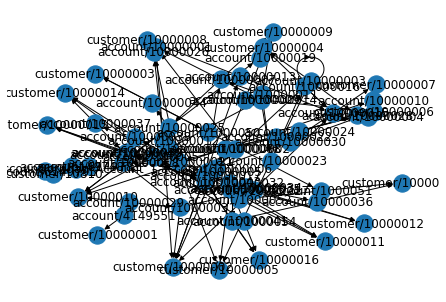

In [20]:
name = "fraud-detection"

# Start from ArangoDB graph
original_fraud_adb_g = db.graph(name)
edge_definitions = original_fraud_adb_g.edge_definitions()

# Create NetworkX graph from ArangoDB graph
fraud_nx_g = adbnx_adapter.arangodb_graph_to_networkx(name)
nx.draw(fraud_nx_g, with_labels=True)


######### Do some stuff with the NetworkX graph here #########
for _, node in fraud_nx_g.nodes(data=True):
    node["new_vertex_data"] = ["new", "vertex", "data", "here"]

for _, _, edge in fraud_nx_g.edges(data=True):
    edge["new_edge_data"] = ["new", "edge", "data", "here"]
# >>> Now it's time to convert the updated NetworkX graph back to ArangoDB!

# Re-use existing graph's edge definitions to create a new ArangoDB graph
# Keify nodes & edges to keep the same key values as original (this is optional)
updated_fraud_adb_g = adbnx_adapter.networkx_to_arangodb(
    name,
    fraud_nx_g,
    edge_definitions,
    keyify_nodes=True,
    keyify_edges=True,
)

print(f"\nInspect the new graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")

#### ArangoDB ➡ NetworkX ➡ ArangoDB (with new collections)

[2022/05/25 17:51:09 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'fraud-detection' Graph
[2022/05/25 17:51:09 +0000] [61] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'TUTloq6b9bm86fckte1cw1tri'
[2022/05/25 17:51:10 +0000] [61] [INFO] - adbnx_adapter: Created ArangoDB 'fraud-detection_new' Graph



View the original graph here: https://tutorials.arangodb.cloud:8529/_db/TUTloq6b9bm86fckte1cw1tri/_admin/aardvark/index.html#graph/fraud-detection
Inspect the new graph here: https://tutorials.arangodb.cloud:8529/_db/TUTloq6b9bm86fckte1cw1tri/_admin/aardvark/index.html#graph/fraud-detection_new



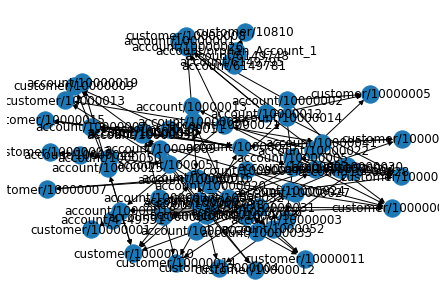

In [25]:
from typing import Set

name = "fraud-detection"

# Start from the ArangoDB graph
original_fraud_adb_g = db.graph(name) 

# Create NetworkX graph from the ArangoDB graph
fraud_nx_g = adbnx_adapter.arangodb_graph_to_networkx(name)
nx.draw(fraud_nx_g, with_labels=True)

######### Do some stuff with the NetworkX graph here #########
# (...)
# >>> Now it's time to convert the updated NetworkX graph back to ArangoDB!

# We must provide edge definitions to create the ArangoDB graph.
edge_definitions = [
    {
        "edge_collection": "accountHolder_new", # Notice the "_new" suffix!
        "from_vertex_collections": ["customer_new"],
        "to_vertex_collections": ["account_new"],
    },
    {
        "edge_collection": "transaction_new",
        "from_vertex_collections": ["account_new"],
        "to_vertex_collections": ["account_new"],
    },
]

class Fraud_ADBNX_Controller(ADBNX_Controller):
  """ArangoDB-NetworkX controller.

  Responsible for controlling how nodes & edges are handled when
  transitioning from ArangoDB to NetworkX, and vice-versa.

  You can derive your own custom ADBNX_Controller.
  """
  # Since we are dealing with a Heterogeneous graph, 
  # we must override _identify_networkx_node().
  def _identify_networkx_node(
      self, nx_node_id: NxId, nx_node: NxData, adb_v_cols: List[str]
  ) -> str:
    """Given a NetworkX node, and a list of ArangoDB vertex collections defined,
    identify which ArangoDB vertex collection it should belong to.

    NOTE: You must override this function if len(**adb_v_cols**) > 1
    OR **nx_node_id* does NOT comply to ArangoDB standards
    (i.e "{collection}/{key}").

    :param nx_node_id: The NetworkX ID of the node.
    :type nx_node_id: adbnx_adapter.typings.NxId
    :param nx_node: The NetworkX node object.
    :type nx_node: adbnx_adapter.typings.NxData
    :param adb_v_cols: All ArangoDB vertex collections specified
        by the **edge_definitions** parameter of networkx_to_arangodb()
    :type adb_v_cols: List[str]
    :return: The ArangoDB collection name
    :rtype: str
    """
    return str(nx_node_id).split("/")[0] + "_new" # Notice the "_new" suffix!

  # Since we are dealing with a Heterogeneous graph, 
  # we must override _identify_networkx_edge().
  def _identify_networkx_edge(
      self,
      nx_edge: NxData,
      from_nx_node: NxData,
      to_nx_node: NxData,
      adb_e_cols: Set[str],
  ) -> str:
    """Given a NetworkX edge, its pair of nodes, and a list of ArangoDB
    edge collections defined, identify which ArangoDB edge collection it
    should belong to.

    NOTE #1: You must override this function if len(**adb_e_cols**) > 1
    OR **nx_edge["_id"]** does NOT comply to ArangoDB standards
    (i.e "{collection}/{key}").

    NOTE #2: The two nodes associated to the **nx_edge** can be accessed
    by the **from_nx_node** & **to_nx_node** parameters, and are guaranteed
    to have the following attributes: `{"nx_id", "adb_id", "adb_col", "adb_key"}`

    :param nx_edge: The NetworkX edge object.
    :type nx_edge: adbnx_adapter.typings.NxData
    :param from_nx_node: The NetworkX node object representing the edge source.
    :type from_nx_node: adbnx_adapter.typings.NxData
    :param to_nx_node: The NetworkX node object representing the edge destination.
    :type to_nx_node: adbnx_adapter.typings.NxData
    :param adb_e_cols: All ArangoDB edge collections specified
        by the **edge_definitions** parameter of
        ADBNX_Adapter.networkx_to_arangodb()
    :type adb_e_cols: List[str]
    :return: The ArangoDB collection name
    :rtype: str
    """
    return str(nx_edge["_id"]).split("/")[0] + "_new" # Notice the "_new" suffix!

# Instantiate the adapter
fraud_adbnx_adapter = ADBNX_Adapter(db, Fraud_ADBNX_Controller())

new_name = name + "_new" # Notice the "_new" suffix!

# Delete the graph if it already exists
db.delete_graph(new_name, drop_collections=True, ignore_missing=True)

# Create a new ArangoDB graph from NetworkX graph
new_fraud_adb_g = fraud_adbnx_adapter.networkx_to_arangodb(
  new_name,
  fraud_nx_g,
  edge_definitions,
  # Keify nodes & edges to keep the same key values as the 
  # original ARangoDB graph (this is optional)
  keyify_nodes=True,
  keyify_edges=True,
)

print(f"\nView the original graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")
print(f"Inspect the new graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{new_name}\n")

#### NetworkX ➡ ArangoDB ➡ NetworkX

[2022/05/25 17:50:58 +0000] [61] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'TUTloq6b9bm86fckte1cw1tri'



-------------------
[((0, 0), {}), ((0, 1), {}), ((0, 2), {}), ((0, 3), {}), ((0, 4), {}), ((1, 0), {}), ((1, 1), {}), ((1, 2), {}), ((1, 3), {}), ((1, 4), {}), ((2, 0), {}), ((2, 1), {}), ((2, 2), {}), ((2, 3), {}), ((2, 4), {}), ((3, 0), {}), ((3, 1), {}), ((3, 2), {}), ((3, 3), {}), ((3, 4), {}), ((4, 0), {}), ((4, 1), {}), ((4, 2), {}), ((4, 3), {}), ((4, 4), {})]
[((0, 0), (1, 0), {}), ((0, 0), (0, 1), {}), ((0, 1), (1, 1), {}), ((0, 1), (0, 2), {}), ((0, 2), (1, 2), {}), ((0, 2), (0, 3), {}), ((0, 3), (1, 3), {}), ((0, 3), (0, 4), {}), ((0, 4), (1, 4), {}), ((1, 0), (2, 0), {}), ((1, 0), (1, 1), {}), ((1, 1), (2, 1), {}), ((1, 1), (1, 2), {}), ((1, 2), (2, 2), {}), ((1, 2), (1, 3), {}), ((1, 3), (2, 3), {}), ((1, 3), (1, 4), {}), ((1, 4), (2, 4), {}), ((2, 0), (3, 0), {}), ((2, 0), (2, 1), {}), ((2, 1), (3, 1), {}), ((2, 1), (2, 2), {}), ((2, 2), (3, 2), {}), ((2, 2), (2, 3), {}), ((2, 3), (3, 3), {}), ((2, 3), (2, 4), {}), ((2, 4), (3, 4), {}), ((3, 0), (4, 0), {}), ((3, 0), (3

[2022/05/25 17:50:59 +0000] [61] [INFO] - adbnx_adapter: Created ArangoDB 'Grid_v2' Graph
[2022/05/25 17:50:59 +0000] [61] [INFO] - adbnx_adapter: Created NetworkX 'Grid_v2' Graph



-------------------
[((0, 0), {'_key': '00', '_id': (0, 0), '_rev': '_eNvV2Z----'}), ((0, 1), {'_key': '01', '_id': (0, 1), '_rev': '_eNvV2Z---_'}), ((0, 2), {'_key': '02', '_id': (0, 2), '_rev': '_eNvV2Z---A'}), ((0, 3), {'_key': '03', '_id': (0, 3), '_rev': '_eNvV2Z---B'}), ((0, 4), {'_key': '04', '_id': (0, 4), '_rev': '_eNvV2Z---C'}), ((1, 0), {'_key': '10', '_id': (1, 0), '_rev': '_eNvV2Z---D'}), ((1, 1), {'_key': '11', '_id': (1, 1), '_rev': '_eNvV2Z---E'}), ((1, 2), {'_key': '12', '_id': (1, 2), '_rev': '_eNvV2Z---F'}), ((1, 3), {'_key': '13', '_id': (1, 3), '_rev': '_eNvV2Z---G'}), ((1, 4), {'_key': '14', '_id': (1, 4), '_rev': '_eNvV2Z---H'}), ((2, 0), {'_key': '20', '_id': (2, 0), '_rev': '_eNvV2Z---I'}), ((2, 1), {'_key': '21', '_id': (2, 1), '_rev': '_eNvV2Z---J'}), ((2, 2), {'_key': '22', '_id': (2, 2), '_rev': '_eNvV2Z---L'}), ((2, 3), {'_key': '23', '_id': (2, 3), '_rev': '_eNvV2Z---M'}), ((2, 4), {'_key': '24', '_id': (2, 4), '_rev': '_eNvV2Z---N'}), ((3, 0), {'_key': 

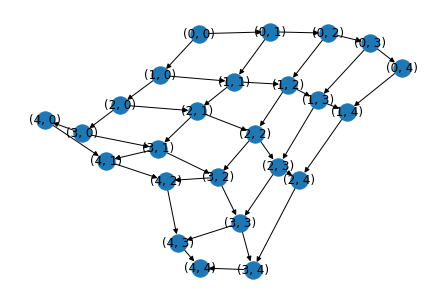

In [24]:
# Load the NetworkX graph
original_grid_nx_g = nx.grid_2d_graph(5, 5)
print('\n-------------------')
print(original_grid_nx_g.nodes(data=True))
print(original_grid_nx_g.edges(data=True))
print('-------------------\n')


# We must provide edge definitions to create the ArangoDB graph
# Since this graph is Homogeneous, we only need one edge definition.
edge_definitions = [
    {
        "edge_collection": "to_v2",
        "from_vertex_collections": ["Grid_Node_v2"],
        "to_vertex_collections": ["Grid_Node_v2"],
    }
]

# Re-introduce the Grid controller class
class Grid_ADBNX_Controller(ADBNX_Controller):
    def _prepare_arangodb_vertex(self, adb_vertex: Json, col: str) -> None:
        """Prepare an ArangoDB vertex before it gets inserted into the NetworkX
        graph.

        Given an ArangoDB vertex, you can modify it before it gets inserted
        into the NetworkX graph, and/or derive a custom node id for NetworkX
        to use by updating the "_id" attribute of the vertex (otherwise the
        vertex's current "_id" value will be used)

        :param adb_vertex: The ArangoDB vertex object to (optionally) modify.
        :type adb_vertex: adbnx_adapter.typings.Json
        :param col: The ArangoDB collection the vertex belongs to.
        :type col: str
        """
        adb_vertex["_id"] = tuple(
            int(n)
            for n in tuple(
                adb_vertex["_key"],
            )
        )
        return

    def _keyify_networkx_node(self, nx_node_id: NxId, nx_node: NxData, col: str) -> str:
        """Given a NetworkX node, derive its valid ArangoDB key.

        NOTE: You must override this function if you want to create custom ArangoDB _key
        values from your NetworkX nodes. To enable the use of this method, enable the
        **keyify_nodes** parameter in ADBNX_Adapter.networkx_to_arangodb().

        :param nx_node_id: The NetworkX node id.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param col: The ArangoDB collection the node belongs to.
        :type col: str
        :return: A valid ArangoDB _key value.
        :rtype: str
        """
        return self._tuple_to_arangodb_key_helper(nx_node_id)

# Re-instantiate the Grid adapter class
grid_adbnx_adapter = ADBNX_Adapter(db, Grid_ADBNX_Controller())

# Delete the Grid graph if it already exists in ArangoDB
name = "Grid_v2"
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
grid_adbnx_adapter.networkx_to_arangodb(name, original_grid_nx_g, edge_definitions, keyify_nodes=True)

######### Do some stuff with the ArangoDB graph here #########
# (...)
# >>> Now it's time to convert the updated ArangoDB graph back to NetworkX!

# Create the NetworkX graph from the ArangoDB graph
new_grid_nx_g = grid_adbnx_adapter.arangodb_graph_to_networkx(name)

# Draw the new graph
nx.draw(new_grid_nx_g, with_labels=True)
print('\n-------------------')
print(new_grid_nx_g.nodes(data=True))
print(new_grid_nx_g.edges(data=True))
print('-------------------\n')